# Explanation

## Dataset Loading (Steps 1–2):

-   The code loads images from the folder "BSD500".
-   `tf.image.decode_jpeg` is used to decode the images.
-   Images are resized to 128×128.
-   Images are converted to grayscale.
-   Images are normalized.

## Impulse Noise Addition (Step 3):

-   Impulse (salt‐and‐pepper) noise is added to each image.
-   A corresponding binary mask is generated.
-   The noisy images are saved into the folder "noisy".

## Visualization (Step 4):

-   A sample clean image, its noisy version, and the ground‐truth noise mask are displayed.

## Data Splitting (Step 5):

-   The data is split (80/20) into training and test sets.

## Noise Detection (Steps 6–7):

-   A CNN segmentation model (with a simple U-Net–like structure) is defined and trained to predict the impulse noise mask.
-   Training graphs for loss and accuracy are plotted.

## Denoising (Step 8):

-   A CNN autoencoder is defined and trained to restore the clean image from the noisy input.
-   MSE loss (better suited for regression tasks) is used.
-   Training curves for MSE loss are plotted.

## Evaluation (Step 9):

-   The performance of the denoising autoencoder is evaluated using PSNR and SSIM metrics.

## Classical Filtering & Visual Comparison (Step 10):

-   Median and fuzzy filters are applied as classical denoising methods.
-   Their average PSNR is printed.
-   A visual comparison of outputs (clean, noisy, denoised, error maps) is displayed.

In [6]:
##############################################
# Step 1: Import Libraries and Set Up
##############################################
import os
import glob
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import time

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)

##############################################
# Research Parameters
##############################################
IMG_SIZE = (128, 128)           # Target image size
SALT_PROB = 0.1                 # Fraction of pixels to set to 1 (salt)
PEPPER_PROB = 0.1               # Fraction of pixels to set to 0 (pepper)

# Training Parameters
EPOCHS_ND = 15                  # Epochs for noise detection model
EPOCHS_DENOISE = 20             # Epochs for denoising autoencoder
BATCH_SIZE = 32
LEARNING_RATE = 1e-3



In [4]:
##############################################
# Step 2: Load and Preprocess the Dataset
##############################################
data_dir = 'BSDD500'  # Ensure this folder exists in your working directory

# Collect files with common image extensions
extensions = ["*.jpg", "*.jpeg", "*.png", "*.JPG", "*.JPEG", "*.PNG"]
image_files = []
for ext in extensions:
    image_files.extend(glob.glob(os.path.join(data_dir, ext)))
# print("Found files:", image_files)

if not image_files:
    raise ValueError("No image files were found in the folder. Check the folder name and file extensions.")

def load_and_preprocess_image(filename, img_size=IMG_SIZE):
    image_string = tf.io.read_file(filename)
    # Decode JPEG image (assumes images are JPEG)
    img = tf.image.decode_jpeg(image_string, channels=3)
    img = tf.image.resize(img, img_size)
    # Convert RGB image to grayscale (shape: [H, W, 1])
    img = tf.image.rgb_to_grayscale(img)
    img = tf.cast(img, tf.float32) / 255.0
    return img

ds = tf.data.Dataset.from_tensor_slices(image_files)
ds = ds.map(lambda x: load_and_preprocess_image(x), num_parallel_calls=tf.data.AUTOTUNE)
ds = ds.batch(BATCH_SIZE)

images = []
for batch in ds:
    images.append(batch.numpy())
images = np.concatenate(images, axis=0)
print("Loaded images shape:", images.shape)  # Expected: (num_images, 128, 128, 1)



Loaded images shape: (800, 128, 128, 1)


In [5]:
##############################################
# Step 3: Add Salt-and-Pepper Noise and Generate Ground-Truth Mask
##############################################
def add_noise_with_mask(image, salt_prob=SALT_PROB, pepper_prob=PEPPER_PROB):
    """
    image: clean grayscale image in [0,1] with shape (H, W, 1)
    salt_prob: fraction of pixels to set to 1 (salt)
    pepper_prob: fraction of pixels to set to 0 (pepper)
    Returns:
      noisy_image: image with impulse noise added
      noise_mask: binary mask (1 for noisy pixels, 0 otherwise)
    """
    noisy = np.copy(image)
    mask = np.zeros_like(image)
    h, w, _ = image.shape
    num_pixels = h * w
    num_salt = int(np.ceil(salt_prob * num_pixels))
    num_pepper = int(np.ceil(pepper_prob * num_pixels))
    
    # Add salt noise
    salt_coords = [np.random.randint(0, i, num_salt) for i in (h, w)]
    noisy[salt_coords[0], salt_coords[1], :] = 1.0
    mask[salt_coords[0], salt_coords[1], :] = 1.0
    
    # Add pepper noise
    pepper_coords = [np.random.randint(0, i, num_pepper) for i in (h, w)]
    noisy[pepper_coords[0], pepper_coords[1], :] = 0.0
    mask[pepper_coords[0], pepper_coords[1], :] = 1.0
    
    return noisy, mask

noisy_images = []
noise_masks = []
for img in images:
    n_img, n_mask = add_noise_with_mask(img, salt_prob=SALT_PROB, pepper_prob=PEPPER_PROB)
    noisy_images.append(n_img)
    noise_masks.append(n_mask)
noisy_images = np.array(noisy_images)
noise_masks = np.array(noise_masks)
print("Noisy images shape:", noisy_images.shape)
print("Noise masks shape:", noise_masks.shape)

# Save noisy images into folder "noisy"
noisy_dir = "noisy"
if not os.path.exists(noisy_dir):
    os.makedirs(noisy_dir)
for i, orig_file in enumerate(image_files):
    base_name = os.path.basename(orig_file)
    out_path = os.path.join(noisy_dir, base_name)
    img_uint8 = (noisy_images[i].squeeze() * 255).astype(np.uint8)
    cv2.imwrite(out_path, img_uint8)
print("Noisy images saved to:", noisy_dir)

Noisy images shape: (800, 128, 128, 1)
Noise masks shape: (800, 128, 128, 1)
Noisy images saved to: noisy


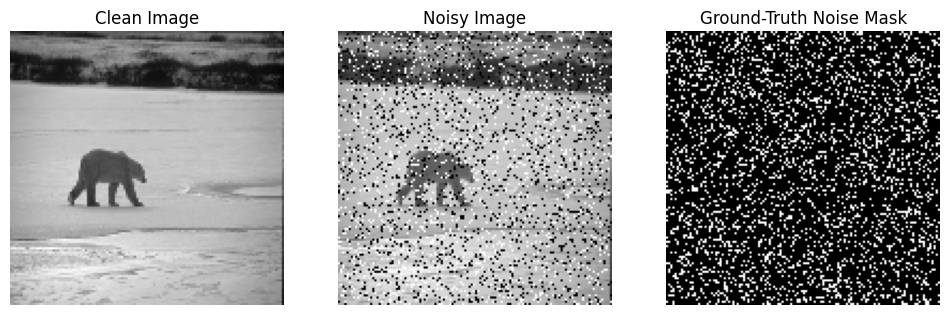

In [7]:
##############################################
# Step 4: Visualize a Sample: Clean, Noisy, and Noise Mask
##############################################
idx = 0  # Change index to visualize a different sample
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(images[idx].squeeze(), cmap="gray")
plt.title("Clean Image")
plt.axis("off")
plt.subplot(1,3,2)
plt.imshow(noisy_images[idx].squeeze(), cmap="gray")
plt.title("Noisy Image")
plt.axis("off")
plt.subplot(1,3,3)
plt.imshow(noise_masks[idx].squeeze(), cmap="gray")
plt.title("Ground-Truth Noise Mask")
plt.axis("off")
plt.show()

In [8]:
##############################################
# Step 5: Split Data into Training and Testing Sets
##############################################
x_train_clean, x_test_clean, x_train_noisy, x_test_noisy, mask_train, mask_test = train_test_split(
    images, noisy_images, noise_masks, test_size=0.2, random_state=42)
print("Train clean:", x_train_clean.shape)
print("Train noisy:", x_train_noisy.shape)
print("Train masks:", mask_train.shape)


Train clean: (640, 128, 128, 1)
Train noisy: (640, 128, 128, 1)
Train masks: (640, 128, 128, 1)


In [9]:
##############################################
# Step 6: Define Noise Detection Model (CNN Segmentation)
##############################################
def noise_detection_model(input_shape=(128,128,1)):
    inputs = tf.keras.Input(shape=input_shape)
    # Encoder
    c1 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    c2 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(p1)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    # Bottleneck
    bn = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(p2)
    # Decoder
    u1 = tf.keras.layers.UpSampling2D((2,2))(bn)
    c3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(u1)
    u2 = tf.keras.layers.UpSampling2D((2,2))(c3)
    c4 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(u2)
    outputs = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c4)
    model = tf.keras.Model(inputs, outputs)
    return model

nd_model = noise_detection_model()
nd_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
nd_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 1)    │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,961 (722.50 KB)

 Trainable params: 184,961 (722.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
18/18 - 47s - 3s/step - accuracy: 0.8170 - loss: 0.5079 - val_accuracy: 0.8186 - val_loss: 0.4821
Epoch 2/15
18/18 - 41s - 2s/step - accuracy: 0.8187 - loss: 0.4789 - val_accuracy: 0.8186 - val_loss: 0.4759
Epoch 3/15
18/18 - 41s - 2s/step - accuracy: 0.8187 - loss: 0.4719 - val_accuracy: 0.8186 - val_loss: 0.4782
Epoch 4/15
18/18 - 41s - 2s/step - accuracy: 0.8187 - loss: 0.4682 - val_accuracy: 0.8186 - val_loss: 0.4626
Epoch 5/15
18/18 - 41s - 2s/step - accuracy: 0.8187 - loss: 0.4605 - val_accuracy: 0.8186 - val_loss: 0.4580
Epoch 6/15
18/18 - 41s - 2s/step - accuracy: 0.8187 - loss: 0.4563 - val_accuracy: 0.8186 - val_loss: 0.4544
Epoch 7/15
18/18 - 40s - 2s/step - accuracy: 0.8187 - loss: 0.4524 - val_accuracy: 0.8186 - val_loss: 0.4500
Epoch 8/15
18/18 - 42s - 2s/step - accuracy: 0.8187 - loss: 0.4486 - val_accuracy: 0.8186 - val_loss: 0.4463
Epoch 9/15
18/18 - 80s - 4s/step - accuracy: 0.8187 - loss: 0.4447 - val_accuracy: 0.8186 - val_loss: 0.4429
Epoch 10/15
18/18 -

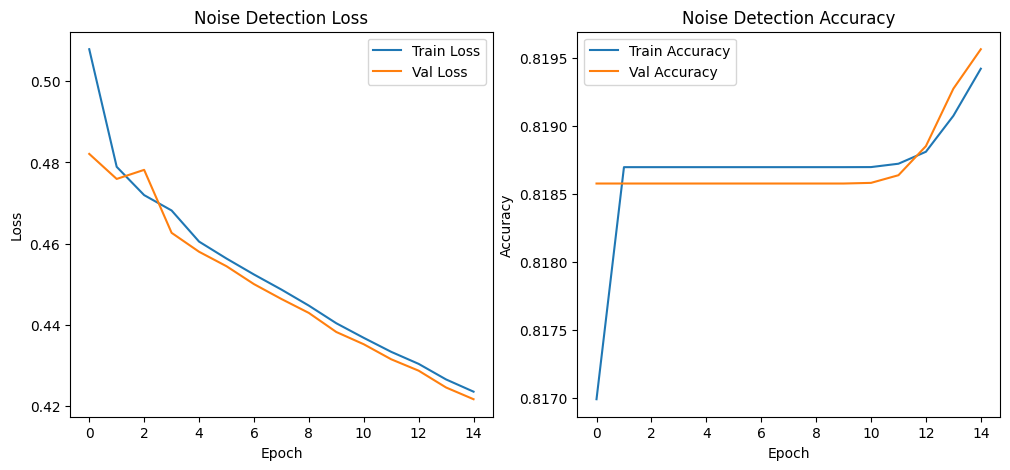

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 414ms/step


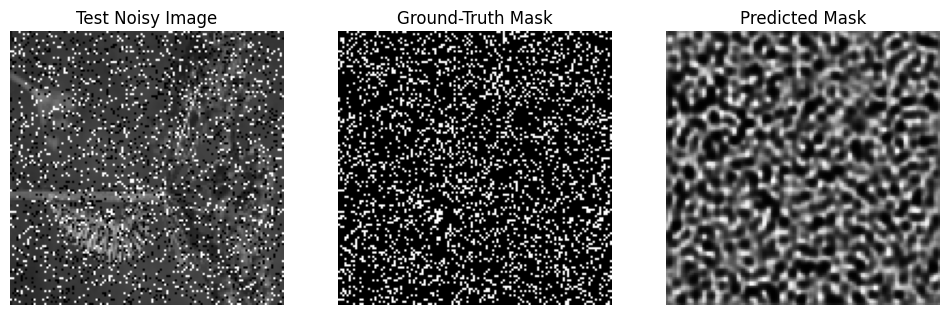

In [10]:
##############################################
# Step 7: Train Noise Detection Model and Plot Training Graphs
##############################################
nd_history = nd_model.fit(x_train_noisy, mask_train, 
                          epochs=EPOCHS_ND, 
                          batch_size=BATCH_SIZE, 
                          validation_split=0.1, 
                          verbose=2)

# Plot noise detection training history (loss & accuracy)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(nd_history.history['loss'], label='Train Loss')
plt.plot(nd_history.history['val_loss'], label='Val Loss')
plt.title("Noise Detection Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(nd_history.history['accuracy'], label='Train Accuracy')
plt.plot(nd_history.history['val_accuracy'], label='Val Accuracy')
plt.title("Noise Detection Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

mask_pred = nd_model.predict(x_test_noisy)
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(x_test_noisy[0].squeeze(), cmap="gray")
plt.title("Test Noisy Image")
plt.axis("off")
plt.subplot(1,3,2)
plt.imshow(mask_test[0].squeeze(), cmap="gray")
plt.title("Ground-Truth Mask")
plt.axis("off")
plt.subplot(1,3,3)
plt.imshow(mask_pred[0].squeeze(), cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")
plt.show()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,193 (47.63 KB)

 Trainable params: 12,193 (47.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
18/18 - 11s - 616ms/step - loss: 0.0390 - mse: 0.0390 - val_loss: 0.0168 - val_mse: 0.0168
Epoch 2/20
18/18 - 6s - 317ms/step - loss: 0.0173 - mse: 0.0173 - val_loss: 0.0148 - val_mse: 0.0148
Epoch 3/20
18/18 - 6s - 321ms/step - loss: 0.0145 - mse: 0.0145 - val_loss: 0.0131 - val_mse: 0.0131
Epoch 4/20
18/18 - 12s - 643ms/step - loss: 0.0132 - mse: 0.0132 - val_loss: 0.0120 - val_mse: 0.0120
Epoch 5/20
18/18 - 6s - 334ms/step - loss: 0.0124 - mse: 0.0124 - val_loss: 0.0114 - val_mse: 0.0114
Epoch 6/20
18/18 - 10s - 549ms/step - loss: 0.0119 - mse: 0.0119 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 7/20
18/18 - 6s - 311ms/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0108 - val_mse: 0.0108
Epoch 8/20
18/18 - 6s - 311ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 9/20
18/18 - 12s - 651ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 10/20
18/18 - 6s - 310ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0100 - v

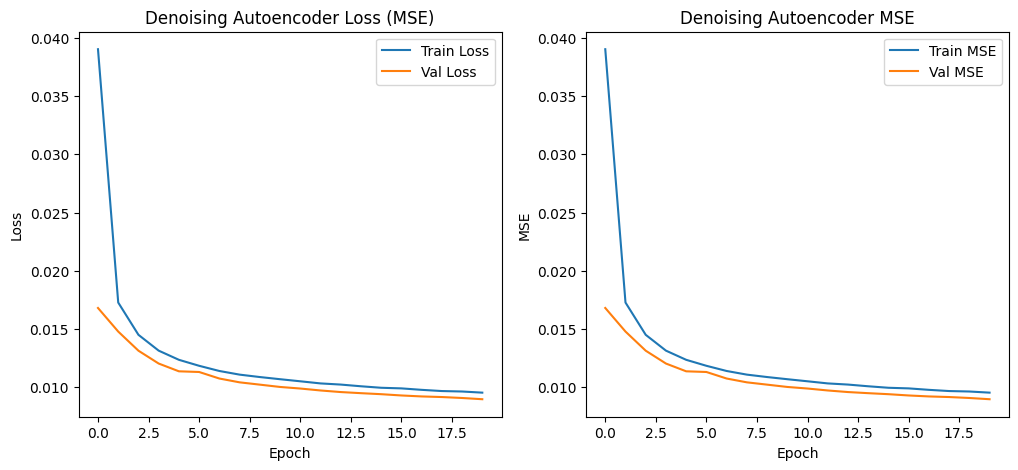

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step


In [11]:
##############################################
# Step 8: Define & Train Denoising Autoencoder
##############################################
def denoising_autoencoder(input_shape=(128,128,1)):
    input_img = tf.keras.Input(shape=input_shape)
    # Encoder
    x = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
    x = tf.keras.layers.MaxPooling2D((2,2), padding='same')(x)
    x = tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same')(x)
    encoded = tf.keras.layers.MaxPooling2D((2,2), padding='same')(x)
    # Decoder
    x = tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same')(encoded)
    x = tf.keras.layers.UpSampling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2,2))(x)
    decoded = tf.keras.layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)
    autoencoder = tf.keras.Model(input_img, decoded)
    return autoencoder

denoise_model = denoising_autoencoder()
# Using MSE loss for denoising
denoise_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                      loss='mse',
                      metrics=['mse'])
denoise_model.summary()

denoise_history = denoise_model.fit(x_train_noisy, x_train_clean, 
                                    epochs=EPOCHS_DENOISE, 
                                    batch_size=BATCH_SIZE, 
                                    validation_split=0.1, 
                                    verbose=2)

# Plot denoising training history (loss & MSE)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(denoise_history.history['loss'], label='Train Loss')
plt.plot(denoise_history.history['val_loss'], label='Val Loss')
plt.title("Denoising Autoencoder Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(denoise_history.history['mse'], label='Train MSE')
plt.plot(denoise_history.history['val_mse'], label='Val MSE')
plt.title("Denoising Autoencoder MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

denoised_images = denoise_model.predict(x_test_noisy)

In [12]:

##############################################
# Step 9: Evaluate Denoising Performance Using PSNR and SSIM
##############################################
def psnr(target, ref):
    mse = np.mean((target - ref) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 1.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

def compute_ssim(target, ref):
    # Ensure target and ref have shape [H, W, 1]
    if len(target.shape) == 2:
        target = target[..., np.newaxis]
    if len(ref.shape) == 2:
        ref = ref[..., np.newaxis]
    return tf.image.ssim(tf.convert_to_tensor(target), tf.convert_to_tensor(ref), max_val=1.0).numpy()

psnr_values = [psnr(den.squeeze(), clean.squeeze()) for den, clean in zip(denoised_images, x_test_clean)]
ssim_values = [compute_ssim(den.squeeze(), clean.squeeze()) for den, clean in zip(denoised_images, x_test_clean)]
avg_psnr = np.mean(psnr_values)
avg_ssim = np.mean(ssim_values)
print("Average PSNR for Autoencoder Denoiser: {:.2f}".format(avg_psnr))
print("Average SSIM for Autoencoder Denoiser: {:.4f}".format(avg_ssim))

Average PSNR for Autoencoder Denoiser: 21.04
Average SSIM for Autoencoder Denoiser: 0.4777


In [15]:
##############################################
# Step 10: Classical Noise Filtering Methods & Visual Comparison
##############################################
# a) Median Filter
def median_filter_denoising(image):
    img_uint8 = (image.squeeze() * 255).astype(np.uint8)
    denoised = cv2.medianBlur(img_uint8, 3)
    return denoised.astype(np.float32) / 255.

median_denoised = np.array([median_filter_denoising(img) for img in x_test_noisy])
psnr_median = np.mean([psnr(den, clean.squeeze()) for den, clean in zip(median_denoised, x_test_clean)])
print("Average PSNR for Median Filter: {:.2f}".format(psnr_median))

# b) Fuzzy Filter
def fuzzy_filter(image, window_size=3):
    h, w = image.shape
    padded = np.pad(image, pad_width=window_size//2, mode='reflect')
    denoised = np.zeros_like(image)
    sigma = 0.1
    for i in range(h):
        for j in range(w):
            window = padded[i:i+window_size, j:j+window_size]
            center = image[i,j]
            weights = np.exp(-np.abs(window - center) / sigma)
            denoised[i,j] = np.sum(window * weights) / np.sum(weights)
    return denoised

fuzzy_denoised = np.array([fuzzy_filter(img.squeeze()) for img in x_test_noisy])
psnr_fuzzy = np.mean([psnr(den, clean.squeeze()) for den, clean in zip(fuzzy_denoised, x_test_clean)])
print("Average PSNR for Fuzzy Filter: {:.2f}".format(psnr_fuzzy))

Average PSNR for Median Filter: 23.11
Average PSNR for Fuzzy Filter: 12.78


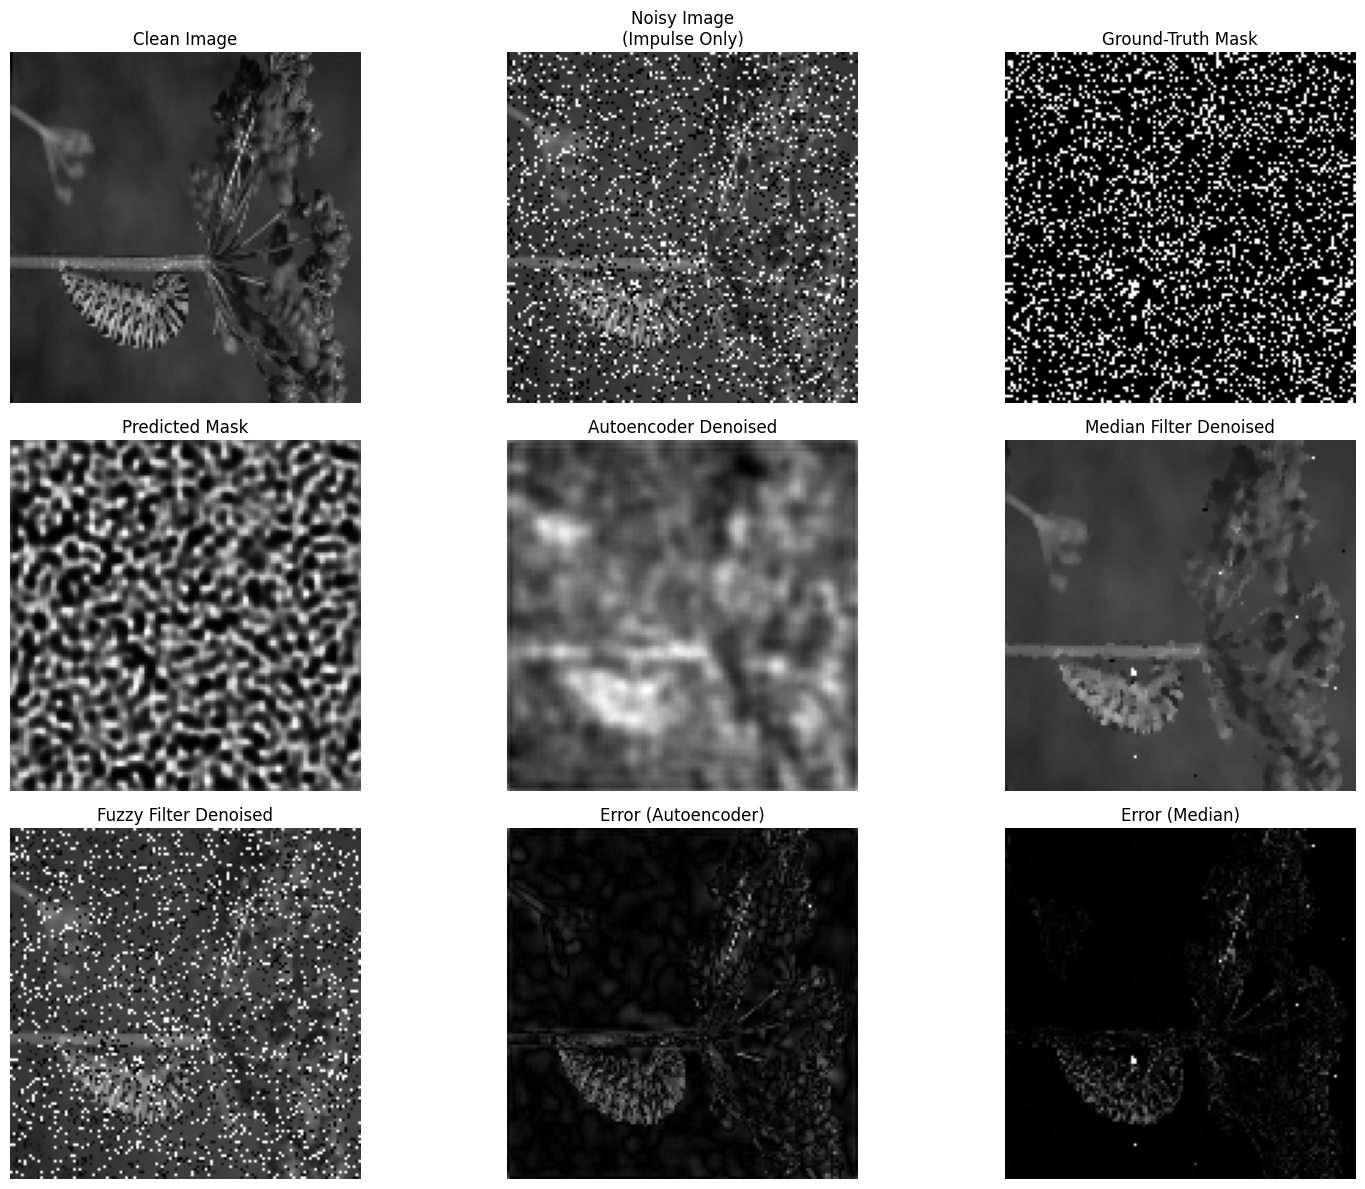

In [16]:
# Visual Comparison for one test sample
idx = 0
plt.figure(figsize=(16,12))
plt.subplot(3,3,1)
plt.imshow(x_test_clean[idx].squeeze(), cmap="gray")
plt.title("Clean Image")
plt.axis("off")
plt.subplot(3,3,2)
plt.imshow(x_test_noisy[idx].squeeze(), cmap="gray")
plt.title("Noisy Image\n(Impulse Only)")
plt.axis("off")
plt.subplot(3,3,3)
plt.imshow(mask_test[idx].squeeze(), cmap="gray")
plt.title("Ground-Truth Mask")
plt.axis("off")
plt.subplot(3,3,4)
plt.imshow(mask_pred[idx].squeeze(), cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")
plt.subplot(3,3,5)
plt.imshow(denoised_images[idx].squeeze(), cmap="gray")
plt.title("Autoencoder Denoised")
plt.axis("off")
plt.subplot(3,3,6)
plt.imshow(median_denoised[idx], cmap="gray")
plt.title("Median Filter Denoised")
plt.axis("off")
plt.subplot(3,3,7)
plt.imshow(fuzzy_denoised[idx], cmap="gray")
plt.title("Fuzzy Filter Denoised")
plt.axis("off")
plt.subplot(3,3,8)
plt.imshow(np.abs(x_test_clean[idx].squeeze() - denoised_images[idx].squeeze()), cmap="gray")
plt.title("Error (Autoencoder)")
plt.axis("off")
plt.subplot(3,3,9)
plt.imshow(np.abs(x_test_clean[idx].squeeze() - median_denoised[idx]), cmap="gray")
plt.title("Error (Median)")
plt.axis("off")
plt.tight_layout()
plt.show()

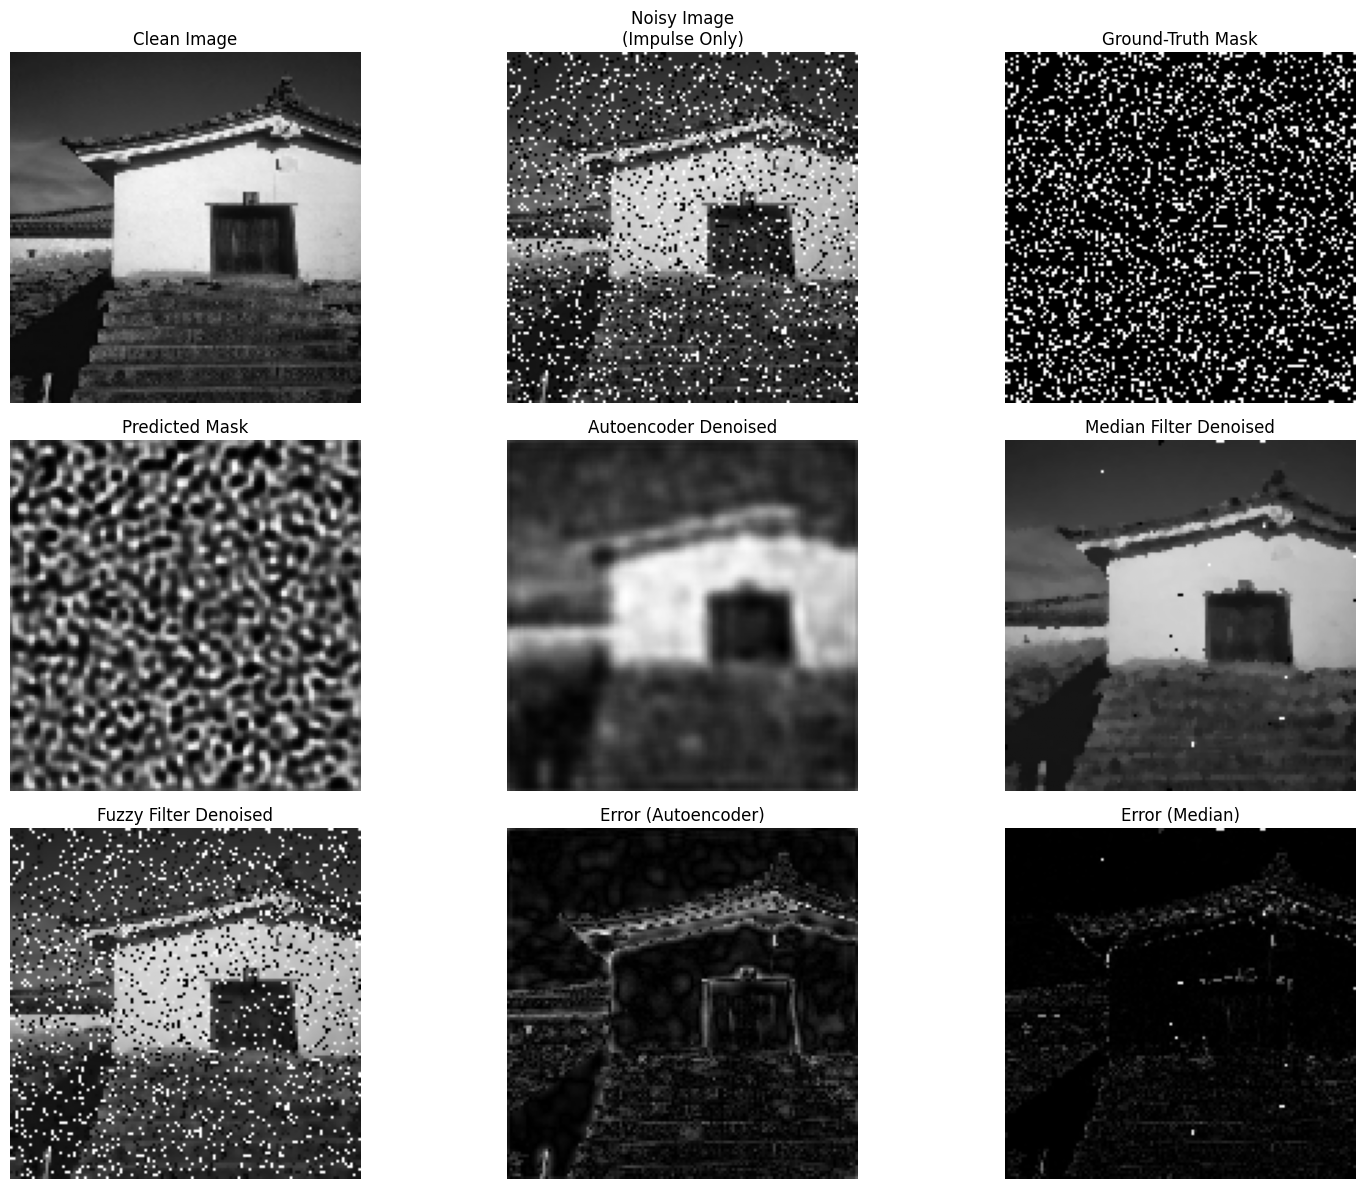

In [18]:
# Visual Comparison for one test sample
idx = 133
plt.figure(figsize=(16,12))
plt.subplot(3,3,1)
plt.imshow(x_test_clean[idx].squeeze(), cmap="gray")
plt.title("Clean Image")
plt.axis("off")
plt.subplot(3,3,2)
plt.imshow(x_test_noisy[idx].squeeze(), cmap="gray")
plt.title("Noisy Image\n(Impulse Only)")
plt.axis("off")
plt.subplot(3,3,3)
plt.imshow(mask_test[idx].squeeze(), cmap="gray")
plt.title("Ground-Truth Mask")
plt.axis("off")
plt.subplot(3,3,4)
plt.imshow(mask_pred[idx].squeeze(), cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")
plt.subplot(3,3,5)
plt.imshow(denoised_images[idx].squeeze(), cmap="gray")
plt.title("Autoencoder Denoised")
plt.axis("off")
plt.subplot(3,3,6)
plt.imshow(median_denoised[idx], cmap="gray")
plt.title("Median Filter Denoised")
plt.axis("off")
plt.subplot(3,3,7)
plt.imshow(fuzzy_denoised[idx], cmap="gray")
plt.title("Fuzzy Filter Denoised")
plt.axis("off")
plt.subplot(3,3,8)
plt.imshow(np.abs(x_test_clean[idx].squeeze() - denoised_images[idx].squeeze()), cmap="gray")
plt.title("Error (Autoencoder)")
plt.axis("off")
plt.subplot(3,3,9)
plt.imshow(np.abs(x_test_clean[idx].squeeze() - median_denoised[idx]), cmap="gray")
plt.title("Error (Median)")
plt.axis("off")
plt.tight_layout()
plt.show()